In [103]:
import pandas as pd
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<AxesSubplot:>

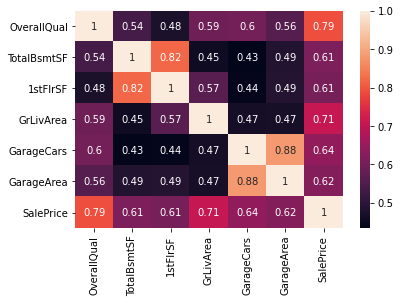

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

correlation_matrix = train.corr()
features = corrmat.index[abs(corrmat["SalePrice"])>0.6]
sns.heatmap(train[features].corr(),annot=True)

# Most highly correleated variables to focus on is OverallQual and GrLivArea

In [38]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

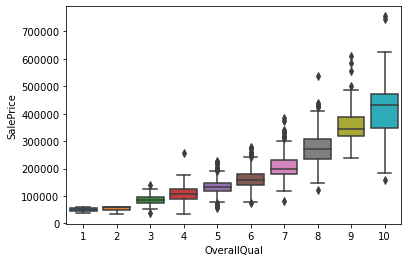

In [31]:
salesPriceConcatOverallQual = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
sns.boxplot(x='OverallQual', y='SalePrice', data=salesPriceConcatOverallQual)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

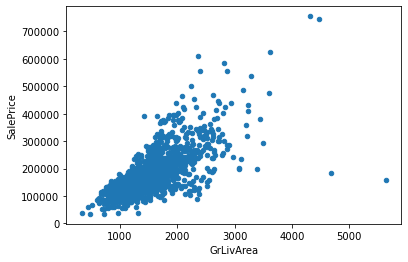

In [32]:
train.plot.scatter(x='GrLivArea', y='SalePrice')

In [56]:
indexNames = [train[(train['SalePrice'] <= 300000) & (train['GrLivArea'] > 4000)]].index
train = train.drop(indexNames, inplace=True)
#Drop outliers

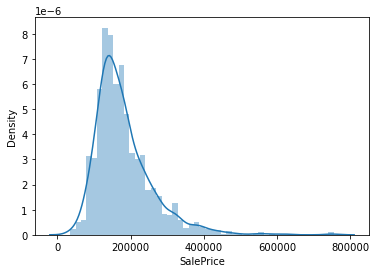

In [33]:
sns.distplot(train['SalePrice']);

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

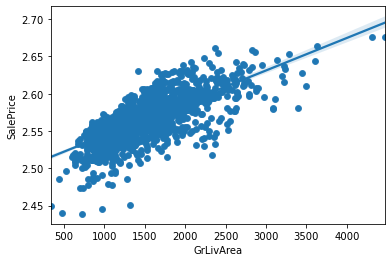

In [66]:
train.plot.scatter(x='GrLivArea', y='SalePrice')
sns.regplot(train['GrLivArea'],train['SalePrice'])

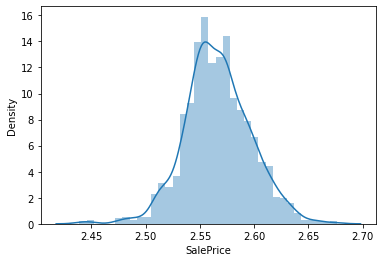

In [64]:
#Apply Log transformation
train.SalePrice = np.log1p(train.SalePrice )
sns.distplot(train['SalePrice'])

train_y = train.SalePrice.values

In [91]:
# Seperate numerical and categorical features
num_feat = train.select_dtypes(exclude=['object']).columns.drop("SalePrice")
cat_feat = train.select_dtypes(include=['object']).columns
feat = pd.concat((train, test)).reset_index(drop=True)

trainNum = train[num_feat]
trainCat = train[cat_feat]

# Fill in missing values using mean
trainNum = trainNum.fillna(trainNum.mean())

# Normalize skew for features
skewAdj = trainNum.apply(lambda l : skew(l))
skewedFeatures = train[skewAdj[abs(skewAdj) > .6].index]

#apply log tranformation to skewed features and store values back in train
train[skewedFeatures.index] = np.log1p(train[skewedFeatures.index])

In [95]:
# Drop irrelevant columns that can't be normalized and are irrelevant
feat = feat.drop(['ScreenPorch','GarageYrBlt','PoolArea','GarageArea','Fireplaces',
                 'MasVnrArea','2ndFlrSF'], axis=1)

In [122]:
# Model
xTrain = feat[:train.shape[0]]
xTest = feat[train.shape[0]:]
yPred = train.SalePrice

kfolds = KFold(n_splits=24, shuffle=True, random_state=50)

def RMSE_CrossValidate_Train(model) :
    RMSE = np.sqrt(-cross_val_score(model, xTrain, yPred, 
                                    scoring="neg_mean_squared_error", cv = kfolds))
    return(RMSE)    

def RMSE_CrossValidate_Test(model) :
    RMSE = np.sqrt(-cross_val_score(model, xTest, yPred, 
                                    scoring="neg_mean_squared_error", cv = kfolds))
    return(RMSE)  
    
model_ridge = Ridge()

alphas = [0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]
RidgeCVTrain = [RMSE_CrossValidate_Train(Ridge(alpha = alpha)).mean() for alpha in alphas]
RidgeCVTest = [RMSE_CrossValidate_Test(Ridge(alpha = alpha)).mean() for alpha in alphas]


print("Ridge on training set: ", RidgeCVTrain) 
print("Ridge on test set: ", RidgeCVTest)  

Ridge on training set:  0.13569143023403368
Ridge on test set:  0.18341136537632105
